In [ ]:
import os
print(os.environ)

environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.5.3.2-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'COLAB_JUPYTER_TRANSPORT': 'ipc', 'NV_NVML_DEV_VERSION': '12.5.82-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn9-cuda-12', 'CGROUP_MEMORY_EVENTS': '/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.22.3-1+cuda12.5', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.22.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.253', 'MODEL_PROXY_HOST': 'https://mp.kaggle.net', 'HOSTNAME': 'fd93c9b2501d', 'LANGUAGE': 'en_US', 'TBE_RUNTIME_ADDR': '172.28.0.1:8011', 'COLAB_TPU_1VM': '', 'GCE_METADATA_TIMEOUT': '3', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.5 brand=unknown,driver>=470,driver<471 brand=grid,driver>=470,driver<471 brand=tesla,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=vapps,driver>=470,driver<471 brand=vpc,driver>=47

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/EfficientNet"
!ls $DATA_DIR

 archive.zip  'BrainTumor_amcnn (1).ipynb'   Model   Testing   Training


In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 740.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 150.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
# =======================================================
# Cell 1 — TPU Setup & Imports
# =======================================================
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from sklearn.utils import class_weight
import numpy as np
import os
import matplotlib.pyplot as plt

# TPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    print("Running on default strategy (CPU/GPU)")

print("Number of replicas:", strategy.num_replicas_in_sync)

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Running on default strategy (CPU/GPU)
Number of replicas: 1


In [ ]:
# =======================================================
# Cell 2 — Check Dataset Stats
# =======================================================
import os
ROOT_DIR = "/content/drive/MyDrive/EfficientNet"
for split in ["Training", "Testing"]:
    dataset_path = os.path.join(ROOT_DIR, split)
    print(f"\n{split} dataset:")
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            print(f"{class_name}: {len(os.listdir(class_path))} images")


Training dataset:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Testing dataset:
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


In [ ]:
# =======================================================
# Cell 3 — TPU-Optimized Preprocessing & Data Generators
# =======================================================
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (300, 300)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
ROOT_DIR = "/content/drive/MyDrive/EfficientNet"

# --- Data augmentation layer (can be applied only on training) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    layers.RandomContrast(0.1),
])

# --- Training and Validation Datasets ---
train_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT_DIR, "Training"),
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT_DIR, "Training"),
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# --- Apply augmentation to training only ---
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y),
                            num_parallel_calls=AUTOTUNE)

# --- Test Dataset ---
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(ROOT_DIR, "Testing"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical'
)

# --- Prefetch for TPU ---
train_data = train_data.prefetch(AUTOTUNE)
val_data = val_data.prefetch(AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

# --- Class weights (same as before) ---
import numpy as np
from sklearn.utils import class_weight

# Collect labels for class weight calculation
labels = np.concatenate([y.numpy() for x, y in train_data], axis=0)
labels = np.argmax(labels, axis=1)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights_dict)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.

Class Weights: {0: np.float64(1.0608170844939646), 1: np.float64(1.048165137614679), 2: np.float64(0.9161988773055333), 3: np.float64(0.9883217993079585)}


In [ ]:
# =======================================================
# Safe Attention Block & EfficientNetB3 Model
# =======================================================
def global_avg_pool(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

def global_max_pool(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

def attention_block(x, ratio=8):
    channel = x.shape[-1]

    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)

    avg_fc = layers.Dense(channel//ratio, activation='relu')(avg_pool)
    avg_fc = layers.Dense(channel, activation='sigmoid')(avg_fc)

    max_fc = layers.Dense(channel//ratio, activation='relu')(max_pool)
    max_fc = layers.Dense(channel, activation='sigmoid')(max_fc)

    channel_attention = layers.Add()([avg_fc, max_fc])
    channel_attention = layers.Reshape((1,1,channel))(channel_attention)
    x = layers.Multiply()([x, channel_attention])

    # Spatial Attention (SAFE now)
    avg_pool = layers.Lambda(global_avg_pool)(x)
    max_pool = layers.Lambda(global_max_pool)(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)

    return layers.Multiply()([x, spatial_attention])

def build_efficientnet_attention(input_shape=(300,300,3), num_classes=4, dropout_rate=0.5, train_base=False):
    base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = train_base  # Phase 1: False, Phase 2: True

    inp = layers.Input(shape=input_shape)
    x = base_model(inp, training=False)
    x = attention_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(num_classes, activation="softmax",
                       kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    return models.Model(inputs=inp, outputs=out, name="EfficientNetB3_Attention")

In [ ]:
# =======================================================
# Cell 5 — Focal Loss Function
# =======================================================
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        return K.sum(weight * cross_entropy, axis=1)
    return focal_loss_fixed

In [ ]:
import json

model_dir = "/content/drive/MyDrive/EfficientNet/Model"
os.makedirs(model_dir, exist_ok=True)

# Checkpoint path
ckpt_path = os.path.join(model_dir, "best_effnetB3_phase1.keras")
history_path = os.path.join(model_dir, "phase1_history.json")

# Callbacks (defined once)
reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

history_phase1_list = []
CHUNK_SIZE = 5
TOTAL_EPOCHS = 20

# --- Detect last completed epoch automatically ---
resume_epoch = 0
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        saved_history = json.load(f)
        if "epoch" in saved_history:
            resume_epoch = max(saved_history["epoch"])
print(f"\n🔄 Resuming from epoch {resume_epoch}")

for start_epoch in range(resume_epoch, TOTAL_EPOCHS, CHUNK_SIZE):
    end_epoch = min(start_epoch + CHUNK_SIZE, TOTAL_EPOCHS)
    print(f"\n🔹 Training Phase 1: Epochs {start_epoch+1} → {end_epoch}")

    if start_epoch == 0 and resume_epoch == 0:
        # First run: build model
        with strategy.scope():
            model = build_efficientnet_attention(train_base=False)
            opt = optimizers.Adam(learning_rate=1e-3)
            model.compile(optimizer=opt,
                          loss=focal_loss(),
                          metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                                   tf.keras.metrics.Recall(name='recall')])
    else:
        # Resume from checkpoint
        model = tf.keras.models.load_model(
            ckpt_path,
            custom_objects={'focal_loss_fixed': focal_loss(),
                            'attention_block': attention_block,
                            'global_avg_pool': global_avg_pool,
                            'global_max_pool': global_max_pool}
        )

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )

    history = model.fit(
        train_data,
        initial_epoch=start_epoch,
        epochs=end_epoch,
        validation_data=val_data,
        class_weight=class_weights_dict,
        callbacks=[checkpoint_cb, reduce_cb, early_cb],
        verbose=1
    )

    # Save history progress
    epoch_range = list(range(start_epoch+1, end_epoch+1))
    history_dict = {"epoch": epoch_range, "history": history.history}
    if os.path.exists(history_path):
        with open(history_path, "r") as f:
            old_history = json.load(f)
        old_history["epoch"].extend(history_dict["epoch"])
        for k, v in history_dict["history"].items():
            old_history["history"].setdefault(k, []).extend(v)
        with open(history_path, "w") as f:
            json.dump(old_history, f)
    else:
        with open(history_path, "w") as f:
            json.dump(history_dict, f)

    history_phase1_list.append(history.history)


🔄 Resuming from epoch 20


In [ ]:
# =======================================================
# Phase 2 — Fine-Tuning EfficientNetB3 in Chunks (Auto Resume)
# =======================================================
history_phase2_list = []
CHUNK_SIZE = 5
TOTAL_EPOCHS = 40

# Define checkpoint and history paths
ckpt_path_phase2 = os.path.join(model_dir, "best_effnetB3_finetuned.keras")
history_path_phase2 = os.path.join(model_dir, "phase2_history.json")

# Resume from JSON if available
resume_epoch = 0
if os.path.exists(history_path_phase2):
    with open(history_path_phase2, "r") as f:
        saved_history = json.load(f)
        if "epoch" in saved_history and len(saved_history["epoch"]) > 0:
            resume_epoch = max(saved_history["epoch"])

print(f"\n🔄 Resuming Phase 2 from epoch {resume_epoch}")

for start_epoch in range(resume_epoch, TOTAL_EPOCHS, CHUNK_SIZE):
    end_epoch = min(start_epoch + CHUNK_SIZE, TOTAL_EPOCHS)
    print(f"\n🔹 Training Phase 2: Epochs {start_epoch+1} → {end_epoch}")

    if start_epoch == 0 and resume_epoch == 0:
        # First time Phase 2: Load best Phase 1 model
        model = tf.keras.models.load_model(
            os.path.join(model_dir, "best_effnetB3_phase1.keras"),
            custom_objects={'focal_loss_fixed': focal_loss(),
                            'attention_block': attention_block,
                            'global_avg_pool': global_avg_pool,
                            'global_max_pool': global_max_pool}
        )

        with strategy.scope():
            # Unfreeze top layers for fine-tuning
            base_model = model.layers[1]  # EfficientNet backbone
            base_model.trainable = True
            for layer in base_model.layers[:-100]:
                layer.trainable = False

            opt = optimizers.Adam(learning_rate=1e-5)
            model.compile(optimizer=opt,
                          loss=focal_loss(),
                          metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                                   tf.keras.metrics.Recall(name='recall')])
    else:
        # Resume from last Phase 2 checkpoint
        model = tf.keras.models.load_model(
            ckpt_path_phase2,
            custom_objects={'focal_loss_fixed': focal_loss(),
                            'attention_block': attention_block,
                            'global_avg_pool': global_avg_pool,
                            'global_max_pool': global_max_pool}
        )

    # Callbacks
    checkpoint_cb2 = tf.keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path_phase2,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )

    # Train chunk
    history = model.fit(
        train_data,
        initial_epoch=start_epoch,
        epochs=end_epoch,
        validation_data=val_data,
        class_weight=class_weights_dict,
        callbacks=[checkpoint_cb2, reduce_cb, early_cb],
        verbose=1
    )

    history_phase2_list.append(history.history)

    # ✅ Save progress to JSON
    if os.path.exists(history_path_phase2):
        with open(history_path_phase2, "r") as f:
            prev_hist = json.load(f)
    else:
        prev_hist = {"epoch": []}

    prev_hist["epoch"].extend(list(range(start_epoch, end_epoch)))
    with open(history_path_phase2, "w") as f:
        json.dump(prev_hist, f)


🔄 Resuming Phase 2 from epoch 34

🔹 Training Phase 2: Epochs 35 → 39
Epoch 35/39
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9798 - auc: 0.9994 - loss: 0.0058 - recall: 0.9761
Epoch 35: val_accuracy improved from -inf to 0.96410, saving model to /content/drive/MyDrive/EfficientNet/Model/best_effnetB3_finetuned.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.9798 - auc: 0.9994 - loss: 0.0058 - recall: 0.9761 - val_accuracy: 0.9641 - val_auc: 0.9967 - val_loss: 0.0150 - val_recall: 0.9615 - learning_rate: 1.0000e-05
Epoch 36/39
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9851 - auc: 0.9996 - loss: 0.0050 - recall: 0.9832
Epoch 36: val_accuracy did not improve from 0.96410
143/143 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9851 - auc: 0.9996 - loss: 0.0050 - recall: 0.9831 - val_accuracy: 0.9641 - val_auc: 0.9966 - val_loss: 0.0160 - val_recall: 0.9615 - learning_rate: 1.0000e-05
Epoch 37/39
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822

In [ ]:

# =======================================================
# Save Final Model
# =======================================================
final_model_path = os.path.join(model_dir, "final_effnetB3_attention.keras")
model.save(final_model_path)

print(f"✅ Final trained model saved at: {final_model_path}")

✅ Final trained model saved at: /content/drive/MyDrive/EfficientNet/Model/final_effnetB3_attention.keras



📊 Full Training Log Across Phase 1 + Phase 2:

Epoch 001 | loss: 0.0051, acc: 0.9825, val_loss: 0.0150, val_acc: 0.9641, auc: 0.9996, val_auc: 0.9967, recall: 0.9790, val_recall: 0.9615
Epoch 002 | loss: 0.0048, acc: 0.9847, val_loss: 0.0160, val_acc: 0.9641, auc: 0.9996, val_auc: 0.9966, recall: 0.9821, val_recall: 0.9615
Epoch 003 | loss: 0.0048, acc: 0.9842, val_loss: 0.0153, val_acc: 0.9658, auc: 0.9996, val_auc: 0.9968, recall: 0.9796, val_recall: 0.9623
Epoch 004 | loss: 0.0045, acc: 0.9871, val_loss: 0.0162, val_acc: 0.9641, auc: 0.9997, val_auc: 0.9965, recall: 0.9842, val_recall: 0.9606
Epoch 005 | loss: 0.0041, acc: 0.9862, val_loss: 0.0155, val_acc: 0.9632, auc: 0.9998, val_auc: 0.9966, recall: 0.9842, val_recall: 0.9580
Epoch 006 | loss: 0.0040, acc: 0.9886, val_loss: 0.0156, val_acc: 0.9641, auc: 0.9998, val_auc: 0.9967, recall: 0.9853, val_recall: 0.9623


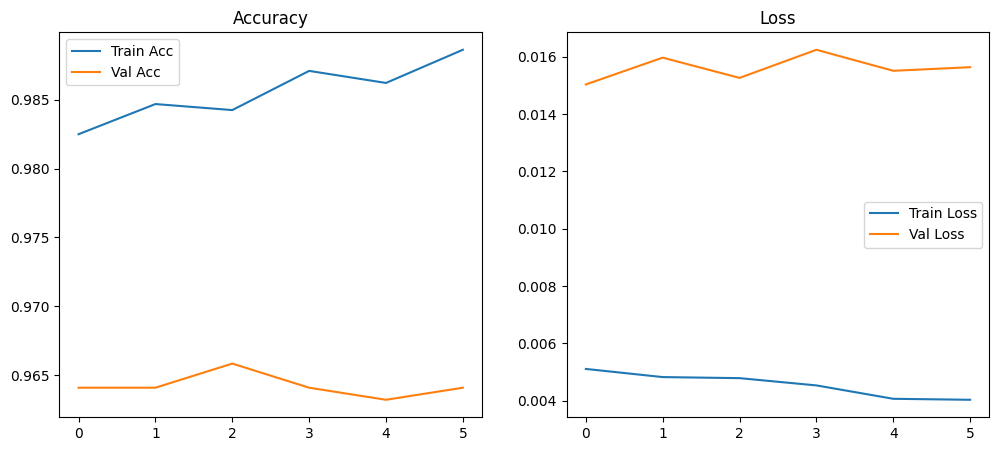

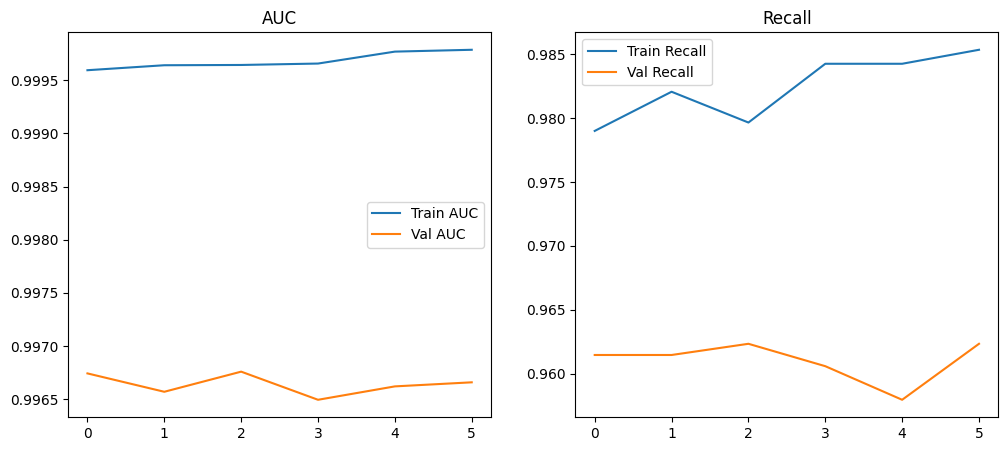

In [ ]:
# =======================================================
# Cell 8 — Merge & Plot Training History (for chunk training)
# =======================================================
import matplotlib.pyplot as plt

def merge_histories(hist_list):
    merged = {'accuracy': [], 'val_accuracy': [],
              'loss': [], 'val_loss': [],
              'auc': [], 'val_auc': [],
              'recall': [], 'val_recall': []}

    for h in hist_list:
        for k in merged.keys():
            if k in h:
                merged[k].extend(h[k])
    return merged

# Merge phase histories
merged_phase1 = merge_histories(history_phase1_list)
merged_phase2 = merge_histories(history_phase2_list)

# Combine into one full history
full_history = {k: merged_phase1.get(k, []) + merged_phase2.get(k, []) for k in merged_phase1.keys()}

# =======================================================
# 🔹 Print full training log (epoch-by-epoch)
# =======================================================
print("\n📊 Full Training Log Across Phase 1 + Phase 2:\n")
for i in range(len(full_history['loss'])):
    print(f"Epoch {i+1:03d} | "
          f"loss: {full_history['loss'][i]:.4f}, "
          f"acc: {full_history['accuracy'][i]:.4f}, "
          f"val_loss: {full_history['val_loss'][i]:.4f}, "
          f"val_acc: {full_history['val_accuracy'][i]:.4f}, "
          f"auc: {full_history['auc'][i]:.4f}, "
          f"val_auc: {full_history['val_auc'][i]:.4f}, "
          f"recall: {full_history['recall'][i]:.4f}, "
          f"val_recall: {full_history['val_recall'][i]:.4f}")

# --- Plot Accuracy & Loss ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# --- Plot AUC & Recall ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(full_history['auc'], label='Train AUC')
plt.plot(full_history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_history['recall'], label='Train Recall')
plt.plot(full_history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.legend()
plt.show()

In [ ]:
# =======================================================
# Cell 9 — Evaluate on Validation & Test
# =======================================================
model = tf.keras.models.load_model(
    os.path.join(model_dir, "best_effnetB3_finetuned.keras"),
    custom_objects={
        'focal_loss_fixed': focal_loss(),
        'attention_block': attention_block,
        'global_avg_pool': global_avg_pool,
        'global_max_pool': global_max_pool
    }
)

# --- Evaluate on Validation ---
val_loss, val_acc, val_auc, val_recall = model.evaluate(val_data, verbose=1)
print(f"Validation — loss: {val_loss:.4f}, acc: {val_acc:.4f}, auc: {val_auc:.4f}, recall: {val_recall:.4f}")

# --- Evaluate on Test ---
test_loss, test_acc, test_auc, test_recall = model.evaluate(test_data, verbose=1)
print(f"Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}, auc: {test_auc:.4f}, recall: {test_recall:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 907ms/step

📊 Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.94      0.96       300
  meningioma       0.94      0.95      0.95       306
   pituitary       1.00      0.99      0.99       405
    no_tumor       0.97      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



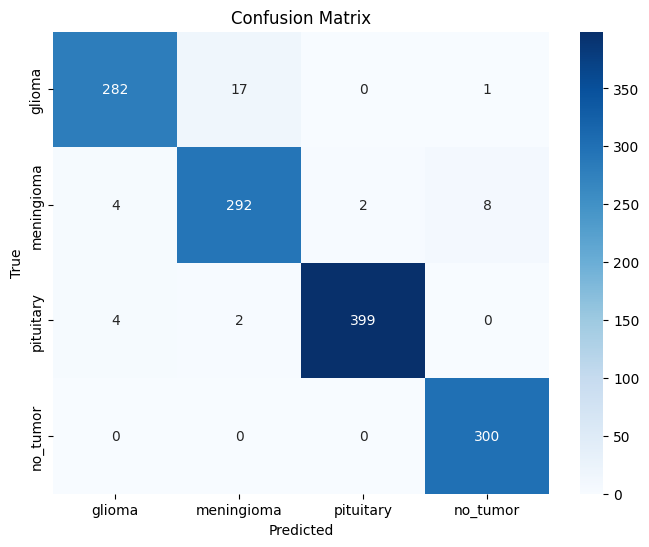

In [ ]:
# =======================================================
# Confusion Matrix & Classification Report (TPU/GPU/CPU Compatible)
# =======================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Collect true labels from test dataset ---
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# --- Predictions ---
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- Define class names manually ---
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# --- Classification report ---
print("\n📊 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))

# --- Confusion matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 866ms/step

📊 Classification Report:

              precision    recall  f1-score   support

      glioma     0.9724    0.9400    0.9559       300
  meningioma     0.9389    0.9542    0.9465       306
   pituitary     0.9950    0.9852    0.9901       405
    no_tumor     0.9709    1.0000    0.9852       300

    accuracy                         0.9710      1311
   macro avg     0.9693    0.9699    0.9694      1311
weighted avg     0.9712    0.9710    0.9710      1311


🔹 Macro F1-score: 0.9694
🔹 Weighted F1-score: 0.9710


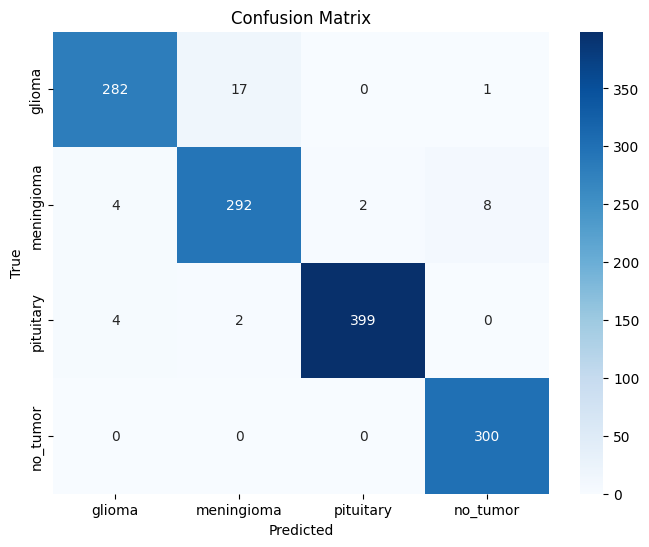

In [ ]:
# =======================================================
# Confusion Matrix & Classification Report (with F1 Score)
# =======================================================
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Collect true labels from test dataset ---
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# --- Predictions ---
y_pred = model.predict(test_data, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# --- Define class names manually ---
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# --- Classification report (includes Precision, Recall, F1, Support) ---
print("\n📊 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES, digits=4))

# --- Compute and print overall F1-score ---
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"\n🔹 Macro F1-score: {f1_macro:.4f}")
print(f"🔹 Weighted F1-score: {f1_weighted:.4f}")

# --- Confusion matrix ---
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

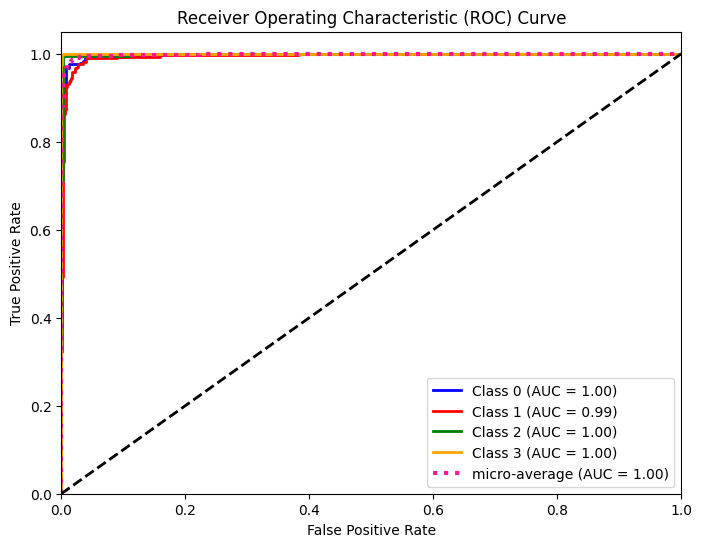

In [ ]:
# =======================================================
# ROC Curves (TPU-Compatible)
# =======================================================
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# One-hot encoding is already present in y_true
y_true_onehot = y_true
n_classes = y_true_onehot.shape[1]

colors = cycle(['blue', 'red', 'green', 'orange'])
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))

# --- ROC for each class ---
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# --- Micro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=3)

# --- Plot settings ---
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

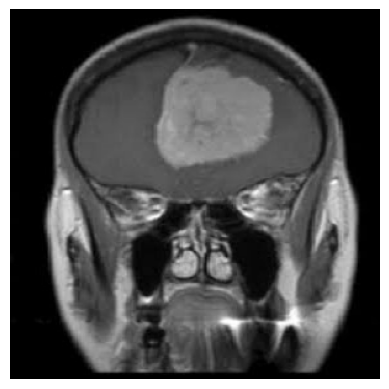

Predicted class: pituitary
Prediction probabilities: [0.23520814 0.15020591 0.49607268 0.11851326]
❌ Not Meningioma (Predicted: pituitary)


In [ ]:
# =======================================================
# Sample Prediction for a Single MRI Image
# =======================================================
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# --- Image path ---
img_path = "/content/drive/MyDrive/EfficientNet/Testing/meningioma/Te-me_0028.jpg"

# --- Load and display image ---
img = load_img(img_path, target_size=IMG_SIZE, color_mode='rgb')
plt.imshow(img)
plt.axis('off')
plt.show()

# --- Preprocess image ---
input_arr = img_to_array(img) / 255.0          # Normalize
input_arr = np.expand_dims(input_arr, axis=0)  # Add batch dimension

# --- Prediction ---
pred = model.predict(input_arr, verbose=0)
pred_class = np.argmax(pred, axis=1)[0]

# --- Define class names manually ---
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# --- Output ---
print(f"Predicted class: {CLASS_NAMES[pred_class]}")
print(f"Prediction probabilities: {pred[0]}")

if CLASS_NAMES[pred_class] == "meningioma":
    print("✅ The MRI shows **Meningioma**")
else:
    print(f"❌ Not Meningioma (Predicted: {CLASS_NAMES[pred_class]})")